Edges found: {(1, 5): 1, (5, 9): 2, (8, 9): 3, (1, 8): 4, (7, 9): 5, (4, 7): 6, (4, 8): 7, (2, 5): 8, (2, 6): 9, (6, 9): 10, (3, 6): 11, (3, 7): 12}


UnboundLocalError: cannot access local variable 'y' where it is not associated with a value

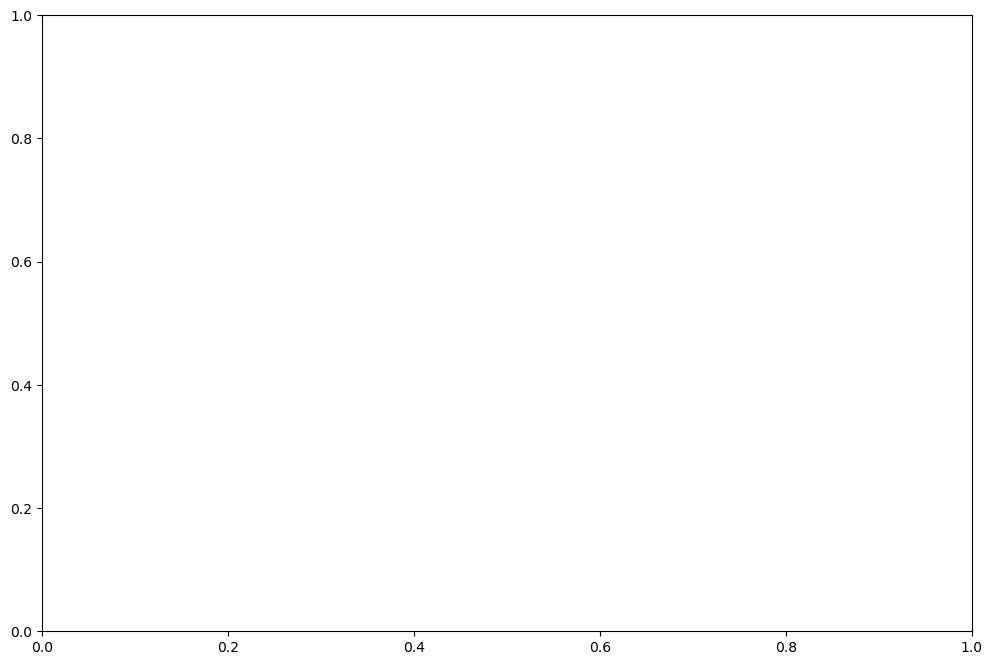

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def read_gmsh_msh(filename):
    """读取Gmsh 2.2格式的MSH文件，返回节点和单元信息"""
    nodes = []
    elements = []
    with open(filename, 'r') as f:
        lines = f.readlines()
        i = 0
        while i < len(lines):
            line = lines[i].strip()
            if line == '$Nodes':
                i += 1
                num_nodes = int(lines[i].strip())
                i += 1
                for _ in range(num_nodes):
                    node_data = lines[i].split()
                    node_id = int(node_data[0])
                    x, y, z = map(float, node_data[1:4])
                    nodes.append((node_id, x, y))  # 仅保留2D坐标 (x, y)
                    i += 1
            elif line == '$Elements':
                i += 1
                num_elements = int(lines[i].strip())
                i += 1
                for _ in range(num_elements):
                    elem_data = lines[i].split()
                    elem_id = int(elem_data[0])
                    elem_type = int(elem_data[1])
                    num_tags = int(elem_data[2])
                    # 处理三角形 (type 2) 和四边形 (type 3)
                    if elem_type in [2, 3]:
                        node_ids = list(map(int, elem_data[3 + num_tags:]))
                        elements.append((elem_id, elem_type, node_ids))
                    i += 1
            else:
                i += 1
    return nodes, elements

def get_edges_from_elements(elements):
    """从三角形或四边形单元中提取边，并为每条边分配编号"""
    edges = {}
    edge_id = 1
    for _, elem_type, node_ids in elements:
        # 三角形：3条边
        if elem_type == 2:
            edge_pairs = [(0, 1), (1, 2), (2, 0)]
        # 四边形：4条边
        elif elem_type == 3:
            edge_pairs = [(0, 1), (1, 2), (2, 3), (3, 0)]
        
        for idx1, idx2 in edge_pairs:
            # 边由两个节点组成，排序以确保一致性
            edge = tuple(sorted([node_ids[idx1], node_ids[idx2]]))
            if edge not in edges:
                edges[edge] = edge_id
                edge_id += 1
    print("Edges found:", edges)
    return edges

def plot_mesh(nodes, elements, edges, filename="mesh_plot.png"):
    """绘制网格，标注单元编号和边编号"""
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # 节点字典
    node_dict = {nid: (x, y) for nid, x, _ in nodes}
    
    # 绘制单元（三角形或四边形）
    for elem_id, elem_type, node_ids in elements:
        # 闭合节点列表
        x = [node_dict[nid][0] for nid in node_ids] + [node_dict[node_ids[0]][0]]
        y = [node_dict[nid][1] for nid in node_ids] + [node_dict[node_ids[0]][1]]
        ax.plot(x, y, 'b-', linewidth=0.5, alpha=0.3)  # 淡蓝色边框
        
        # 计算质心并标注单元编号
        cx = np.mean([node_dict[nid][0] for nid in node_ids])
        cy = np.mean([node_dict[nid][1] for nid in node_ids])
        ax.text(cx, cy, f'E{elem_id}', color='red', ha='center', va='center', 
                fontsize=12, fontweight='bold', 
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    
    # 绘制边和边编号
    for edge, edge_id in edges.items():
        n1, n2 = edge
        x1, y1 = node_dict[n1]
        x2, y2 = node_dict[n2]
        # 绘制边
        ax.plot([x1, x2], [y1, y2], 'k-', linewidth=2.5, zorder=2)
        # 边中点标注编号
        mx = (x1 + x2) / 2
        my = (y1 + y2) / 2
        ax.text(mx, my, f'Edge{edge_id}', color='green', ha='center', va='center', 
                fontsize=11, fontweight='bold', zorder=3, 
                bbox=dict(facecolor='white', alpha=0.9, edgecolor='black', boxstyle='round,pad=0.3'))
    
    # 绘制节点
    for nid, x, y in nodes:
        ax.plot(x, y, 'ko', markersize=5, zorder=4)
        ax.text(x, y, f'N{nid}', color='blue', fontsize=8, ha='right', va='bottom', zorder=5)
    
    ax.set_title('Gmsh Mesh with Element, Edge, and Node Numbers')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.grid(True, linestyle='--', alpha=0.5, zorder=0)
    ax.set_aspect('equal')
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

def main(filename):
    nodes, elements = read_gmsh_msh(filename)
    edges = get_edges_from_elements(elements)
    plot_mesh(nodes, elements, edges)

if __name__ == '__main__':
    msh_file = 'data/structured.mesh'  # 替换为你的MSH文件路径
    main(msh_file)